<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/data_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch

from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import shutil
import os
from google.colab import drive
import zipfile

In [16]:

def plot_transaction_counts_over_time(df, date_column='transaction_year',save_dir='./plots/'):
    """
    Plots the number of transactions over time.

    Parameters:
    df (DataFrame): The dataset containing sales transactions.
    date_column (str): The column representing transaction year.
    """
    # Convert to DataFrame (if not already)
    df = pd.DataFrame(df)

    # Count the number of transactions per year
    transaction_counts = df.groupby(date_column).size()

    # Plot the trend
    plt.figure(figsize=(12, 6))
    plt.plot(transaction_counts.index, transaction_counts.values, marker='', linestyle='-', color='blue', label="Number of Transactions")
    plt.legend(loc="upper left", fontsize = 14)
    plt.xlabel("Year of Sale")
    plt.ylabel("Number of Transactions")
    plt.title("")
    plt.grid(False)
    # Save the plot with a filename based on the column name
    save_path = os.path.join(save_dir, f'transaction_numbers_over_time.png')
    plt.tight_layout()
    plt.savefig(save_path)  # Save the plot as a .png file



def plot_avg_sale_prices_over_time(df, date_column='transaction_year', price_column='transaction_price',save_dir='./plots/' ):
    """
    Plots the average sale prices over time.

    Parameters:
    df (DataFrame): The dataset containing sales transactions.
    date_column (str): The column representing transaction year.
    price_column (str): The column representing sale price.
    """
    # Convert to DataFrame (if not already)
    df = pd.DataFrame(df)

    # Group by year and compute the average sale price
    avg_prices = df.groupby(date_column)[price_column].mean()

    # Plot the trend
    plt.figure(figsize=(12, 6))
    plt.plot(avg_prices.index, np.log(avg_prices), marker='', linestyle='-', color='blue', label="Average Sale Price")
    plt.legend(loc="upper left", fontsize = 14)
    plt.xlabel("Year of Sale")
    plt.ylabel("Average Transaction Price (log)")
    plt.title("")
    plt.grid(False)

    # Save the plot with a filename based on the column name
    save_path = os.path.join(save_dir, f'average_price_over_time.png')
    plt.tight_layout()
    plt.savefig(save_path)  # Save the plot as a .png file



def plot_categorical_features(data, categorical_columns, save_dir='./plots/'):
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Sort categorical columns by number of unique values (descending) and take top 20
    top_cats = sorted(categorical_columns, key=lambda col: data[col].nunique(), reverse=True)[:20]

    for column in top_cats:
        fig, ax = plt.subplots(figsize=(8, 5))

        # Use value_counts to sort categories by frequency
        top_categories = data[column].value_counts().nlargest(20).index
        sns.countplot(x=column, data=data[data[column].isin(top_categories)], ax=ax, order=top_categories)

        ax.set_xlabel(column)        # Show column name as x-axis label
        #ax.set_title(f"{column} Distribution")
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

        # Save the plot with a filename based on the column name
        save_path = os.path.join(save_dir, f'{column}_distribution.png')
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close(fig)

def fit_visualization(X, y, save_path=None):
    target = np.array(X, dtype=np.float64)
    prediction_numerical_model = np.array(y, dtype=np.float64)

    r_squared = r2_score(target, prediction_numerical_model)
    slope, intercept, r_value, p_value, std_err = linregress(target, prediction_numerical_model)

    epsilon = 1e-8  # to avoid division by zero
    relative_errors = np.abs(prediction_numerical_model - target) / (np.abs(target) + epsilon)
    mape = np.mean(relative_errors) * 100

    print(f"R-squared: {r_squared:.3f}")
    print(f"MAPE: {mape:.2f}%")

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(target, prediction_numerical_model, alpha=0.5, label='Predictions')

    # Plot the regression line
    plt.plot(target, slope * target + intercept, color='black', label=f'Regression Line (R²={r_squared:.3f}, MAPE={mape:.2f}%)')

    # Plot y=x line (perfect predictions)
    plt.plot([min(target), max(target)], [min(target), max(target)], color='green', linestyle='--', label='45° line')

    # Labels and title
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('')
    plt.legend()

    # Annotate the regression equation on the plot
    equation_text = f"y = {slope:.3f}x + {intercept:.3f}"
    plt.text(min(target), max(prediction_numerical_model) * 0.9, equation_text, fontsize=12, color='black')

    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")

    # Show the plot
    plt.show()

def repeated_to_single_transactions(data):
    """
    Transforms the dataset by splitting purchase and sale data into separate rows
    and renaming columns for consistency.
    """

    df = data.copy().dropna()
    # Columns to keep (common info)

    common_columns = ['category', 'artist', 'height', 'width', 'medium', 'image_url']


    # Sale Data: Keep only relevant columns
    sale_data = df[common_columns + ['sale_year', 'sale_price',
                                     'sale_house', 'sale_date']].copy()
    sale_data = sale_data.rename(columns={
        'sale_price': 'transaction_price',
        'sale_house': 'transaction_house',
        'sale_date': 'transaction_date',
        'sale_year': 'transaction_year'

    })


    # Purchase Data: Keep only relevant columns
    purchase_data = df[common_columns + ['purchase_year', 'purchase_price',
                                         'purchase_house', 'purchase_date']].copy()
    purchase_data = purchase_data.rename(columns={
        'purchase_price': 'transaction_price',
        'purchase_house': 'transaction_house',
        'purchase_date': 'transaction_date',
        'purchase_year': 'transaction_year'
        })

    df_final = pd.concat([sale_data, purchase_data], ignore_index=True)
    #df_final  = df.drop_duplicates(subset=['image_url'], keep='first')

    return df_final



def one_hot(data, one_hot_vars, date_column='transaction_date', expected_format='%m/%d/%Y'):

    df = data.copy()

    # Try to convert the 'transaction_date' to datetime with a specified format
    try:
        df[date_column] = pd.to_datetime(df[date_column], format=expected_format, errors='coerce')
    except ValueError:
        # If the specified format fails, try inferring the format
        df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    df = df.dropna(subset=[date_column])


    # Extract the month from 'transaction_date'
    df['month'] = df[date_column].dt.month


    df = df.drop(columns = ['transaction_date'])
    df_encoded = pd.get_dummies(df, columns=one_hot_vars + ['month'])

    return df_encoded



def data_filter(data, selected_vars, split_year,
                min_price=10000, max_price=200000000,
                min_occurrence=50):

    df = data.copy()

    # Filter by price range
    df = df[(df['transaction_price'] >= min_price) & (df['transaction_price'] <= max_price)]

    # Split into train/test
    train_df = df[df['transaction_year'] < split_year].copy()
    test_df = df[df['transaction_year'] >= split_year].copy()

    # List of categorical variables to filter
    categorical_vars = ['transaction_house', 'artist', 'category', 'medium']

    # Filter each categorical variable based on train set only
    for var in categorical_vars:
        valid_values = train_df[var].value_counts()[lambda x: x >= min_occurrence].index
        train_df = train_df[train_df[var].isin(valid_values)]
        test_df = test_df[test_df[var].isin(valid_values)]


    df_filtered = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
    return df_filtered[selected_vars]



def data_split(data, selected_vars, one_hot_vars, date_filter):
    """
    Splits the data into train and test sets, applies feature engineering,
    and detrends the price using linear regression.
    """
    df = data.copy()

    # Step 1: Transform the data (repeated transactions, add features, etc.)
    df = repeated_to_single_transactions(df)
    df = add_location_column(df, get_location_dict())  # Ensure location column is added if needed

    # Step 2: Filter data based on selected variables
    df = data_filter(df, selected_vars, date_filter)
    df['transaction_price'] = np.log(df['transaction_price'])
    df['aspect_ratio'] = df['width'] / (df['height'] + 1e-6)  # Add small value to avoid div by 0


    # Step 3: Apply one-hot encoding
    df = one_hot(df, one_hot_vars)

    # Step 6: Split into train and test sets based on transaction_year
    train_data = df[df['transaction_year'] < date_filter].copy()
    test_data = df[df['transaction_year'] >= date_filter].copy()

    # Step 7: Prepare X and y for training and testing
    X_train = train_data.drop(columns=['transaction_price'])
    y_train = train_data['transaction_price']  # Use detrended price for training
    X_test = test_data.drop(columns=['transaction_price'])
    y_test = test_data['transaction_price']  # Use detrended price for testing

    # Ensure X_train and X_test have the same columns
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Step 8: Scale numerical features
    numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
    scaler_X = MinMaxScaler()
    X_train[numerical_features] = scaler_X.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler_X.transform(X_test[numerical_features])

    return X_train, X_test, y_train, y_test



def load_image_data(zip_path, image_path):

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()
    file_list = [f for f in file_list if not f.startswith('__MACOSX')]
    zip_ref.extractall(image_path, members=file_list)
  print(f"Dateien entpackt in: {image_path}")



# Function to check if an image file exists
def check_image_existence(image_paths, base_dir):
    missing_images = []  # To store paths of missing images
    nans = 0
    invalid_url = 0
    for image_path in image_paths:
        # Skip if the path is not a valid string (e.g., NaN or None)
        if isinstance(image_path, str) and image_path.strip():  # Check if it's a valid non-empty string
            # Construct the full image path based on the base directory
            full_image_path = os.path.join(base_dir, image_path.lstrip('/'))  # Remove leading slash, if any

            # Check if the file exists
            if not os.path.exists(full_image_path):
                missing_images.append(full_image_path)  # Add to missing list if not found
                invalid_url += 1
        else:
            nans += 1
    print(f"number of nans: {nans}")
    print(f"missing images: {invalid_url}")
    return missing_images

def filter_data_for_missing_images(data, missing_images, base_dir):
    # Extract only relative paths from missing_images
    data = data.dropna(subset=['image_url'])
    missing_relative_paths = [os.path.relpath(img, base_dir) for img in missing_images]
    data_filtered = data[~data['image_url'].str.lstrip('/').isin(missing_relative_paths)]

    return data_filtered

def resnet_transform():
    # Define the transformation pipeline
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),  # Convert PIL image to PyTorch tensor

        # Convert the image to RGB if it has an alpha channel
        torchvision.transforms.Lambda(lambda image: image[:3, :, :] if image.shape[0] == 4 else image),

        # Normalize using the ResNet50's mean and standard deviation
        torchvision.transforms.Normalize((0.485,0.456, 0.406),
                                         (0.229,0.224,0.225))
    ])
    return transform

def column_type_split(x_train, x_test):

    # Copy x_train and x_test to avoid changing them in place
    train_df = x_train.copy()
    test_df = x_test.copy()

    # All columns from both dataframes
    all_columns = list(train_df.columns.union(test_df.columns))

    # Get the columns based on prefixes, maintaining the order from all_columns
    artist_cols = [col for col in all_columns if col.startswith('artist_')]
    medium_cols = [col for col in all_columns if col.startswith('medium_')]
    transaction_house_cols = [col for col in all_columns if col.startswith('transaction_house_')]
    category_cols = [col for col in all_columns if col.startswith('category_')]
    month_cols = [col for col in all_columns if col.startswith('month_')]
    location_cols = [col for col in all_columns if col.startswith('location_')]
    year_cols = [col for col in all_columns if col.startswith('year_')]

    return artist_cols, medium_cols, transaction_house_cols, category_cols, month_cols, location_cols, year_cols

def add_location_column(df, mapping_dict):
    df = df.copy()
    df['location'] = df['transaction_house'].map(mapping_dict).fillna('N/A')
    return df

def get_location_dict():
  return{
    'BL': 'London',
    'BNY': 'New York',
    'BHK': 'Hong Kong',
    'BP': 'Paris',
    'C': 'New York',
    'C SWISS': 'Swiss',
    'CA': 'Amsterdam',
    'CBJ': 'Beijing',
    'C COLOGNE': 'Cologne',
    'CDB': 'Dubai',
    'CDH': 'Doha',
    'CHK': 'Hong Kong',
    'CL': 'London',
    'CLA': 'Los Angeles',
    'CM': 'Monaco',
    'CMB': 'Melbourne',
    'CMI': 'Milan',
    'CP': 'Paris',
    'CR': 'Rome',
    'CSH': 'Shanghai',
    'CSY': 'Sydney',
    'CTR': 'Toronto',
    'CZH': 'Zurich',
    'S': 'New York',
    'SA': 'Amsterdam',
    'SC': 'Chicago',
    'SHK': 'Hong Kong',
    'SL': 'London',
    'SLA': 'Los Angeles',
    'SM': 'Monaco',
    'SMI': 'Milan',
    'SP': 'Paris',
    'S COLOGNE': 'Cologne',
    'S SWISS': 'Swiss',
    'SBJ': 'Beijing',
    'SMB': 'Melbourne',
    'SDH': 'Doha',
    'SSH': 'Shanghai',
    'SSY': 'Sydney',
    'SZH': 'Zurich',
    'SPG': 'New York',
    'STA': 'Tel Aviv',
    'STR': 'Toronto',
    'PNY': 'New York',
    'PPNY': 'New York',
    'PL': 'London',
    'PPLN': 'London',
    'PHK': 'Hong Kong',
    'AAA': 'New York',
    'AG': 'New York',
    'APT': 'Paris',
    'COEUR': 'Paris',
    'D': 'Vienna',
    'DY': 'New York',
    'EG': 'Glasgow',
    'FAA': 'New York',
    'FMC': 'Amsterdam',
    'GC': 'Paris',
    'GGP': 'Paris',
    'GM': 'Paris',
    'GMG': 'Geneva',
    'HD': 'Paris',
    'HF': 'Chicago',
    'HVA': 'Angouleme',
    'HVE': 'Enghien-les-Bains',
    'JD': 'Paris',
    'L': 'Paris',
    'LG': 'London',
    'MC': 'Amsterdam',
    'MH': 'New York',
    'MTL': 'Paris',
    'O': 'N/A',
    'PBG': 'New York',
    'PLG': 'New York',
    'SKB': 'Boston',
    'Artcurial, Paris': 'Paris',
    'POLY HK': 'Hong Kong',
    'POLY BJ': 'Beijing',
    'Guardian HK': 'Hong Kong',
    'Guardian BJ': 'Beijing',
}





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True
363
363
299
299
9
9
25
25
6
6
12
12
8
8
0
0
Index(['height', 'width', 'transaction_year', 'aspect_ratio', 'category_AMP',
       'category_BRP', 'category_IMP', 'category_LAP', 'category_OMP',
       'category_PWC',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object', length=363)
Index(['height', 'width', 'transaction_year', 'aspect_ratio', 'category_AMP',
       'category_BRP', 'category_IMP', 'category_LAP', 'category_OMP',
       'category_PWC',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object', length=363)


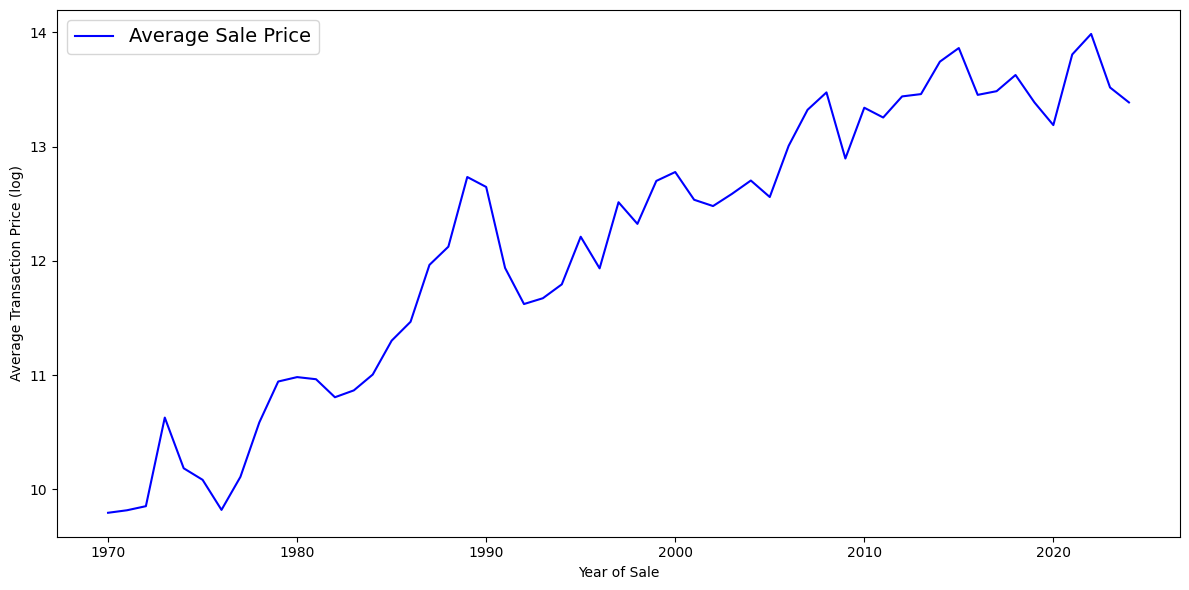

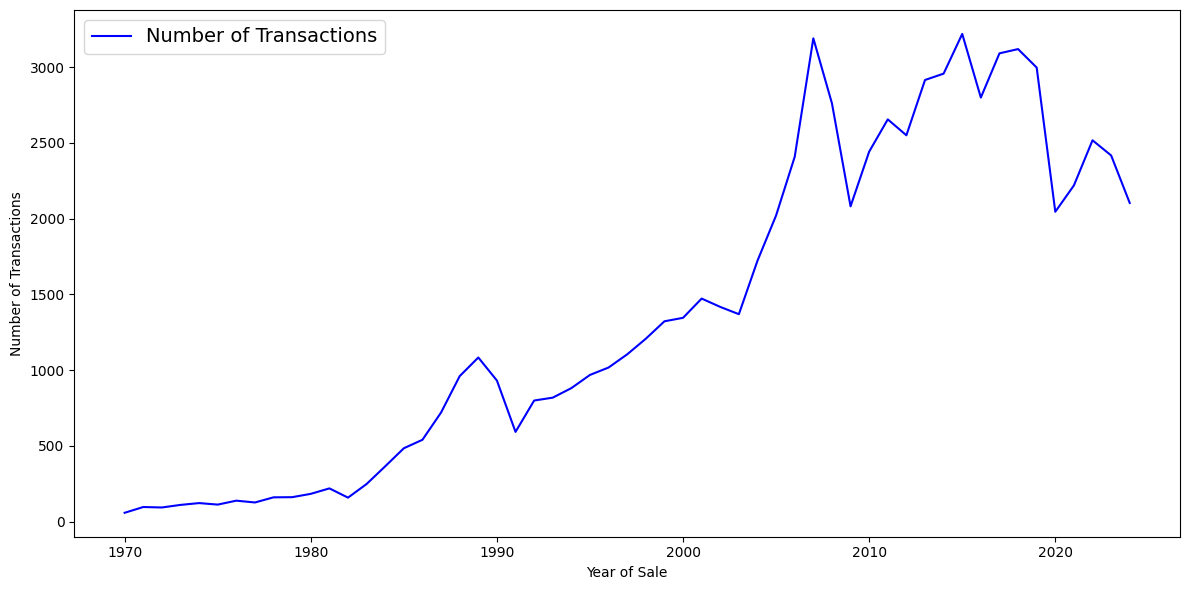

In [17]:
if __name__ == "__main__":


  drive.mount('/content/drive')
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)
  # Define source and destination paths
  source_path = "/content/drive/My Drive/Colab Notebooks/data_preprocess.ipynb"
  destination_path = "/content/drive/My Drive/data_preprocess.ipynb"

  # Check if the source file exists before moving
  if os.path.exists(source_path):
    # Move the file
    shutil.move(source_path, destination_path)
    print(f"Notebook moved to: {destination_path}")



  # visualizations

  visualization_data = repeated_to_single_transactions(artwork_numeric_data)

  #visualization_data.to_csv('/content/drive/My Drive/visualization_data.csv')


  selected_vars =  ['category', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house',
                    'transaction_year','transaction_date', 'location']
  one_hot_vars = ['category', 'artist', 'medium', 'transaction_house', 'location']
  numerical_cols = ['height', 'width', 'transaction_year']


  X_train, X_test, y_train, y_test = data_split(artwork_numeric_data,
                                                   selected_vars,

                                              one_hot_vars, 2022)


  #plot_avg_sale_prices_over_time(visualization_data)
  categorical_columns = ['category', 'transaction_year', 'transaction_house', 'artist', 'medium']


  plot_categorical_features(visualization_data, categorical_columns, save_dir='./plots/')
  plot_avg_sale_prices_over_time(visualization_data)
  plot_transaction_counts_over_time(visualization_data)

  """
  # image


  zip_path = "/content/drive/My Drive/pic.zip"
  extract_path = "/content/data"
  load_image_data(zip_path, extract_path)
  # Check for missing images
  base_dir = "/content/data"
  image_paths = artwork_numeric_data['image_url'].values
  missing_images = check_image_existence(image_paths, base_dir)
  data_filtered = filter_data_for_missing_images(artwork_numeric_data, missing_images, base_dir)
  # check functioning of image data after filtering
  print(f"After filtering:{check_image_existence(data_filtered['image_url'],base_dir)} ")



  # Compute overall stats
  pd.options.display.float_format = '{:,.2f}'.format
  overall_stats = visualization_data["transaction_price"].describe(percentiles=[0.25, 0.5, 0.75]).to_frame().T
  overall_stats.insert(0, "Type", "Overall")
  overall_stats.insert(1, "Name", "All")
  overall_stats = overall_stats.rename(columns={"count": "N", "mean": "mean", "25%": "p25", "50%": "p50", "75%": "p75"})[["Type", "Name", "N", "mean", "p25", "p50", "p75"]]
  print(overall_stats)

  # Function to get top 5 most occurring values with stats
  def get_top_stats(column_name):
    top_5 = visualization_data[column_name].value_counts().nlargest(5)
    stats_list = []

    for name, count in top_5.items():
        stats = visualization_data.loc[visualization_data[column_name] == name, "transaction_price"].describe(percentiles=[0.25, 0.5, 0.75]).to_dict()
        stats["N"] = count
        stats_list.append({"Type": column_name, "Name": name, "N": count, "mean": stats["mean"], "p25": stats["25%"], "p50": stats["50%"], "p75": stats["75%"]})

    return pd.DataFrame(stats_list)

  # Get stats for top artists and transaction houses
  top_artists_stats = get_top_stats("artist")
  top_transaction_houses_stats = get_top_stats("transaction_house")

  # Combine all tables
  final_table = pd.concat([overall_stats, top_artists_stats, top_transaction_houses_stats], ignore_index=True)
  final_table[["N", "mean", "p25", "p50", "p75"]] = final_table[["N", "mean", "p25", "p50", "p75"]].astype(int)


  # Display the final table
  print(final_table.to_latex(index=False))

  """


  print(X_train.columns.equals(X_test.columns))
  print(len(X_train.columns))
  print(len(X_test.columns))
  print(len([x for x in X_train.columns if x.startswith("artist_")]))
  print(len([x for x in X_test.columns if x.startswith("artist_")]))
  print(len([x for x in X_train.columns if x.startswith("medium_")]))
  print(len([x for x in X_test.columns if x.startswith("medium_")]))
  print(len([x for x in X_train.columns if x.startswith("transaction_house_")]))
  print(len([x for x in X_test.columns if x.startswith("transaction_house_")]))
  print(len([x for x in X_train.columns if x.startswith("category_")]))
  print(len([x for x in X_test.columns if x.startswith("category_")]))
  print(len([x for x in X_train.columns if x.startswith("month_")]))
  print(len([x for x in X_test.columns if x.startswith("month_")]))
  print(len([x for x in X_train.columns if x.startswith("location_")]))
  print(len([x for x in X_test.columns if x.startswith("location_")]))
  print(len([x for x in X_train.columns if x.startswith("year")]))
  print(len([x for x in X_test.columns if x.startswith("year")]))



  X_train_columns = pd.DataFrame(X_train.columns)

  # Saving the column names to a CSV file
  X_train_columns.to_csv('X_train_columns.csv', index=False, header=False)
  X_test_columns = pd.DataFrame(X_test.columns)

  # Saving the column names to a CSV file
  X_test_columns.to_csv('X_test_columns.csv', index=False, header=False)



  print(X_train.columns)
  print(X_test.columns)









